In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from netgen.csg import *
from ngsolve import *
from ngsolve.webgui import Draw
# from netgen import gui
from ngsolve.comp import ConvertOperator
import numpy as np

import time

Geometrie: Spule mit Luftspalt und Stahlplatte dazwischen

In [2]:
geo = CSGeometry()
box_size = 2
box = OrthoBrick(Pnt(-box_size,-box_size,-box_size), Pnt(box_size,box_size,box_size)).bc("outer")

lx = 0.4
lz = 0.5
d = 0.1
lp = 0.3
core = OrthoBrick(Pnt(-lx,-d/2,-lz),Pnt(lx,d/2,lz))- \
           OrthoBrick(Pnt(d-lx,-d,-lz+d),Pnt(lx-d,d,lz-d))- \
           OrthoBrick(Pnt(d,-d,-d/2),Pnt(lx+d,d,d/2)).maxh(0.2).mat("core")

plate = OrthoBrick(Pnt(d/2,-lp,-d/4),Pnt(2*lx-d,lp,d/4)).mat('plate')


coil = (Cylinder(Pnt(-lx+d/2,0,0), Pnt(-lx+d/2,0,1), 3*d) - \
        Cylinder(Pnt(-lx+d/2,0,0), Pnt(-lx+d/2,0,1), d)) * \
        OrthoBrick (Pnt(-1,-1,-lz+2*d),Pnt(1,1,lz-2*d)).maxh(0.2).mat('coil')

air = (box - coil - plate -core).mat('air') 

geo.Add(plate)
geo.Add(core)
geo.Add(coil)
geo.Add(air, transparent=True)

mesh = Mesh(geo.GenerateMesh(maxh=0.5))
mesh.Curve(1)
Draw (mesh)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2007-128-gc46d6894b', 'mesh_dim': 3, 'order2d': 1, 'order3d': 1…

$$
\DeclareMathOperator{\Grad}{grad}
\DeclareMathOperator{\Curl}{curl}
\DeclareMathOperator{\Div}{div}
\DeclareMathOperator{\R}{\mathbb{R}}
\DeclareMathOperator{\real}{real}
\DeclareMathOperator{\reg}{reg}
$$
### Magnetostatisches Problem ohne Stahlplatte

Finde $ u \in H(\Curl)$ sodass 
$$
\int \mu^{-1} \Curl u \Curl v + \reg \int  u  v= \int j v \qquad  \forall \, v \in H(\Curl) \tag{1}
$$

Wir nehmen zunächst an, dass der `core` aus einem tollen Material besteht das immer eine hohe, lineare Permeabilität hat. Um in den nichtlinearen Bereich des Stahls zu kommen wollen wir ein Magnetfeld zwischen 1.0 und 1.5 Tesla im Lufspalt. 

In folgender Rechnung wird vernachlässigt, dass der Luftspalt (bzw dann die zwei Luftspalte) kleiner ist wenn sich eine Stahlplatte darin befindet, daher ist das Ziel ohne Stahlplatte auf ca 1T zu kommen. Außerdem wird angenommen dass es keine Streuflüsse gibt. 

Es gilt für das Magnetfeld im Luftspalt $B_l$ gilt $B = \frac{\Phi}{A}$ Wobei $\Phi$ die magnetische Flussdichte und $A$ die Querschnittsfläche des Luftspalts ist. Die von der Spule erzeugte Durchflutung $\Theta$ beträgt $4d(l_z-d)*j$, falls die Stromdichte $j$ konstant ist.  Wenn wir die im Kern abfallende magnetische Spannung vernachlässigen gilt wegen $\Theta = R\Phi$ und des magnetische Widerstands im Luftspalt $R = \frac{d}{\mu_0A}$ dass    

$$ 
4d(l_z-d)j = \Theta = \frac{d}{\mu_0A}\Phi = \frac{d}{\mu_0}B.
$$

Die Stromdichte ergibt sich also ungefähr als 
$$
 j \approx \frac{B}{4\mu_0(l_z-d) } \approx 5*10^5.
$$

Es stellt sich heraus, dass $j \approx 7*10^5$ zum gewünschten einen Tesla führt. 

In [8]:
fes = HCurl(mesh, order = 3, dirichlet="outer", nograds=True)
u,v = fes.TnT()
from math import pi

j = 7*1e5
mu0 = 4*pi*1e-7
mur = { "core" : 1e10, "coil" : 1, "air" : 1, "plate": 1}
nu = CoefficientFunction([1/(mu0*mur[mat]) for mat in mesh.GetMaterials()]) # max: 10^2, min:10^6 
reg = 1e-6*nu

a = BilinearForm(fes)
a += nu*curl(u)*curl(v)*dx + reg*u*v*dx
c = Preconditioner(a, "bddc")

f = LinearForm(fes)
f += CoefficientFunction((-y,lx-d/2+x,0))*CoefficientFunction(1/sqrt(y**2+(lx-d/2+x)**2))*j*v*dx(mesh.Materials('coil'))

gfu = GridFunction(fes)
# Was passiert wenn blf schon linear ist?
# test = gfu.vec.CreateVector()
# test[:] = 0

with TaskManager():
    a.Assemble()
#     a.AssembleLinearization(test)
    f.Assemble()
    solvers.CG(sol=gfu.vec, rhs=f.vec, mat=a.mat, pre=c.mat)


# a.AssembleLinearization(gfu.vec)
# solvers.CG(sol=gfu.vec, rhs=f.vec, mat=a.mat, pre=c.mat)
def show():
    Draw (curl(gfu), mesh, "B-field", draw_surf=False)
    Draw (nu*curl(gfu), mesh, "H-field", draw_surf=False)
    mip = mesh(lx-d/2, 0, 0)
    print(curl(gfu)(mip), np.linalg.norm(curl(gfu)(mip)))
# Draw(CoefficientFunction((-y,lx-d/2+x,0))*CoefficientFunction(1/sqrt(y**2+(lx-d/2+x)**2)), mesh)
show()

iteration 0 error = 433.054132005632
iteration 1 error = 373.65706366308063
iteration 2 error = 379.85076051480917
iteration 3 error = 213.04990144399832
iteration 4 error = 142.68492581926557
iteration 5 error = 85.3188846778717
iteration 6 error = 61.61077672894057
iteration 7 error = 39.90132574933936
iteration 8 error = 24.299494166399608
iteration 9 error = 15.970365476644151
iteration 10 error = 11.20027944782278
iteration 11 error = 9.430786455503782
iteration 12 error = 6.138337430035542
iteration 13 error = 4.354547400335049
iteration 14 error = 3.4447649745829385
iteration 15 error = 2.5011323885882812
iteration 16 error = 1.6741374793811186
iteration 17 error = 1.163184873107048
iteration 18 error = 0.777570492558204
iteration 19 error = 0.5557890631897647
iteration 20 error = 0.5146875494990407
iteration 21 error = 0.30600286144588923
iteration 22 error = 0.2397603851500415
iteration 23 error = 0.15747489570948783
iteration 24 error = 0.12399060027562385
iteration 25 error 

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2007-128-gc46d6894b', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2007-128-gc46d6894b', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2…

(-0.001559534021116321, -0.004935969863055907, -0.707961447318411) 0.7079803717858506


### Magnetostatisches Problem mit Stahlplatte

Ohne dem Regularisierungsterm lautet das nichtlineare Problem:


Finde $ u \in H(\Curl)$ sodass 
$$
\int \underbrace{\frac{1}{\mu(|B|)}\Curl u}_{=H} \Curl v = \int j v \qquad  \forall \, v \in H(\Curl) \tag{2}
$$

Wenn $u$ das Mimimierungsproblem 
$$
F(u) := \int \omega(|\Curl u|) - \int ju  \qquad \min !
$$
mit 
$$
w(x) = \int_0^{x} \frac{1}{\mu(s)}s ~ ds
$$
löst, dann erfüllt $u$ auch (1). 


Um das einzusehen berechne die erste Variation von $F$:
$$
\begin{split}
\lim_{\epsilon \rightarrow 0} \frac{d}{d\epsilon} F(u+\epsilon v) &= \int \lim_{\epsilon \rightarrow 0}\frac{1}{\mu(|\Curl(u+\epsilon v)|)}|\Curl(u+\epsilon v)|\frac{\Curl(u+\epsilon v)}{|\Curl(u+\epsilon v)|}\Curl v  - \int jv\\
&= \int \frac{1}{\mu(|\Curl u|)}\Curl u \Curl v  - \int jv
\end{split}
$$

Die folgende H-B Kurve ist aus der TEAM 13 Lösung von Valentin Hanser:

Text(0, 0.5, 'Magnetic Flux Density B in T')

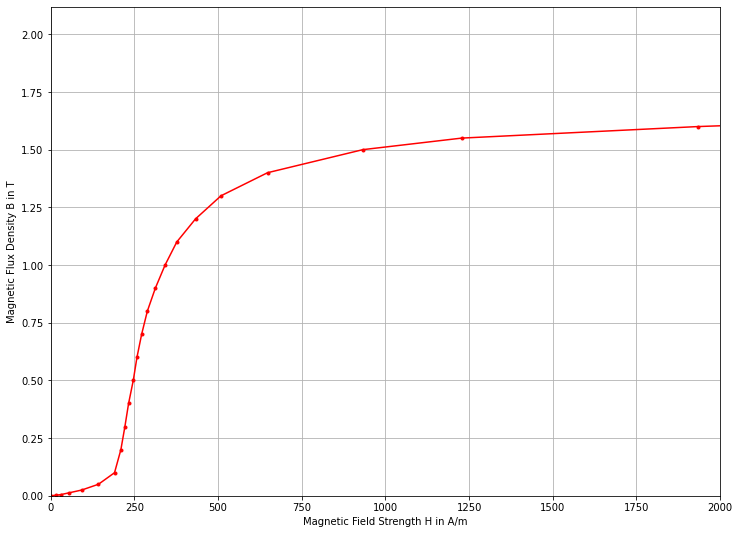

In [3]:
from matplotlib import pyplot as plt

H_KL = [ -4.47197834e-13, 1.60000000e+01, 3.00000000e+01, 5.40000000e+01\
, 9.30000000e+01, 1.43000000e+02, 1.91000000e+02, 2.10000000e+02 \
, 2.22000000e+02, 2.33000000e+02, 2.47000000e+02, 2.58000000e+02\
, 2.72000000e+02, 2.89000000e+02, 3.13000000e+02, 3.42000000e+02\
, 3.77000000e+02, 4.33000000e+02, 5.09000000e+02, 6.48000000e+02\
, 9.33000000e+02, 1.22800000e+03, 1.93400000e+03, 2.91300000e+03\
, 4.99300000e+03, 7.18900000e+03, 9.42300000e+03, 9.42300000e+03\
, 1.28203768e+04, 1.65447489e+04, 2.07163957e+04, 2.55500961e+04\
, 3.15206135e+04, 4.03204637e+04, 7.73038295e+04, 1.29272791e+05\
, 1.81241752e+05, 2.33210713e+05, 2.85179674e+05, 3.37148635e+05\
, 3.89117596e+05, 4.41086557e+05, 4.93055518e+05, 5.45024479e+05\
, 5.96993440e+05, 6.48962401e+05, 7.00931362e+05, 7.52900323e+05\
, 8.04869284e+05, 8.56838245e+05, 9.08807206e+05, 9.60776167e+05\
, 1.01274513e+06, 1.06471409e+06, 1.11668305e+06, 1.16865201e+06\
, 1.22062097e+06, 1.27258993e+06, 1.32455889e+06, 1.37652785e+06\
, 1.42849682e+06, 1.48046578e+06, 1.53243474e+06, 1.58440370e+06\
, 1.63637266e+06, 1.68834162e+06, 1.74031058e+06, 1.79227954e+06\
, 1.84424850e+06, 1.89621746e+06, 1.94818643e+06, 2.00015539e+06\
, 2.05212435e+06, 2.10409331e+06, 2.15606227e+06, 2.20803123e+06\
, 2.26000019e+06]

B_KL = [ 0.00000000e+00, 2.50000000e-03, 5.00000000e-03, 1.25000000e-02\
, 2.50000000e-02, 5.00000000e-02, 1.00000000e-01, 2.00000000e-01\
, 3.00000000e-01, 4.00000000e-01, 5.00000000e-01, 6.00000000e-01\
, 7.00000000e-01, 8.00000000e-01, 9.00000000e-01, 1.00000000e+00\
, 1.10000000e+00, 1.20000000e+00, 1.30000000e+00, 1.40000000e+00\
, 1.50000000e+00, 1.55000000e+00, 1.60000000e+00, 1.65000000e+00\
, 1.70000000e+00, 1.75000000e+00, 1.80000000e+00, 1.80000000e+00\
, 1.86530612e+00, 1.93061224e+00, 1.99591837e+00, 2.06122449e+00\
, 2.12653061e+00, 2.19183673e+00, 2.25714286e+00, 2.32244898e+00\
, 2.38775510e+00, 2.45306122e+00, 2.51836735e+00, 2.58367347e+00\
, 2.64897959e+00, 2.71428571e+00, 2.77959184e+00, 2.84489796e+00\
, 2.91020408e+00, 2.97551020e+00, 3.04081633e+00, 3.10612245e+00\
, 3.17142857e+00, 3.23673469e+00, 3.30204082e+00, 3.36734694e+00\
, 3.43265306e+00, 3.49795918e+00, 3.56326531e+00, 3.62857143e+00\
, 3.69387755e+00, 3.75918367e+00, 3.82448980e+00, 3.88979592e+00\
, 3.95510204e+00, 4.02040816e+00, 4.08571429e+00, 4.15102041e+00\
, 4.21632653e+00, 4.28163265e+00, 4.34693878e+00, 4.41224490e+00\
, 4.47755102e+00, 4.54285714e+00, 4.60816327e+00, 4.67346939e+00\
, 4.73877551e+00, 4.80408163e+00, 4.86938776e+00, 4.93469388e+00\
, 5.00000000e+00]
bh_curve = BSpline (2, [0]+list(B_KL), list(H_KL)) # [0] + is needed!
energy_dens = bh_curve.Integrate()

plt.figure(1, figsize=[12, 9])
plt.clf()
plt.plot(H_KL, B_KL, '.-r')
plt.xlim(0, 2000)
plt.ylim(0, 2.12)
plt.grid()
plt.xlabel("Magnetic Field Strength H in A/m")
plt.ylabel("Magnetic Flux Density B in T")

### Implementierung ähnlich wie im Beipiel

In dem Beipiel wird die schwache Formulierung mit dem Minimierungsproblem gemischt. Gibt es dafür einen Grund?

In [ ]:
fes = HCurl(mesh, order = 3, dirichlet="outer", nograds=True)
u,v = fes.TnT()
from math import pi

j = 3*1e5
mu0 = 4*pi*1e-7
mur = { "core" : 1e8, "coil" : 1, "air" : 1}

a = BilinearForm(fes)
for mat in mur.keys():
    a += 1/(mu0*mur[mat])*curl(u)*curl(v)*dx(mat) + 1e-6*1/(mu0*mur[mat])*u*v*dx(mat)
a += SymbolicEnergy(energy_dens(sqrt(1e-12+ curl(u)*curl(u))), definedon = 'plate') # 1e-12+ ?
a += 1e-3*u*v*dx('plate')
    
## TODO: hier preconditioning Beispiel
c = Preconditioner(a, "bddc")

f = LinearForm(fes)
f += CoefficientFunction((-y,lx-d/2+x,0))*CoefficientFunction(1/sqrt(y**2+(lx-d/2+x)**2)*j)*v*dx(mesh.Materials('coil'))


TOL = 1e-10
MAX_IT = 60

with TaskManager():

    f.Assemble()

    gfu = GridFunction(fes)
    res = gfu.vec.CreateVector()
    w = gfu.vec.CreateVector()
    tmp = gfu.vec.CreateVector()
    
    gfu.vec[:] = 0

    err = 1
    it = 0
    
    while err > TOL and it < MAX_IT:
        it += 1
        
        e_old = a.Energy(gfu.vec) - InnerProduct(f.vec, gfu.vec)
        
        a.Apply(gfu.vec, tmp)
        res.data = tmp - f.vec
        
        a.AssembleLinearization(gfu.vec)
        solvers.CG(sol=w, rhs=res, mat=a.mat, pre=c.mat)
        
        err = abs(InnerProduct(w, res))
        
        print("\n error {} in iteration {}".format(err, it))
        
        tmp.data = gfu.vec - w
        
        e_new = a.Energy(tmp) - InnerProduct(f.vec, tmp)
        print("old energy: {}, new energy: {}".format(e_old, e_new))
        
        tau = 1
        cnt = 1
        while e_new > e_old:
            tau *= max(0.1, 1-0.1*cnt)
            cnt += 1
            tmp.data = gfu.vec - tau*w
            e_new = a.Energy(tmp) - InnerProduct(f.vec, tmp)
            print("new energy: {} with tau: {}".format( e_new, tau))
        
        gfu.vec.data = tmp


def show():
    Draw (curl(gfu), mesh, "B-field", draw_surf=False)
    mip = mesh(lx-d/2, 0, 0)
    print(curl(gfu)(mip), np.linalg.norm(curl(gfu)(mip)))

In [ ]:
show()

### Ganz als Minimierungsproblem

Minimiere das Funktional 

$$
F(u) := \int_{\text{plate}} \omega(|\Curl u|) + \int_{\Omega\setminus\text{plate}} \frac{1}{2\mu}\Curl u + \reg \int \frac{1}{2} u  - \int ju  \tag{3}
$$

Funktioniert viel besser (warum?)

In [9]:
fes = HCurl(mesh, order = 3, dirichlet="outer", nograds=True)
u = fes.TrialFunction()
from math import pi

j = 7*1e2
mu0 = 4*pi*1e-7
mur = { "core" : 1e10, "coil" : 1, "air" : 1}

a = BilinearForm(fes)
for mat in mur.keys():
    a += Variation( 1/(2*mu0*mur[mat])*curl(u)*curl(u)*dx(mat) + 1e-6*1/(2*mu0*mur[mat])*u*u*dx(mat))
a += Variation(energy_dens(sqrt(1e-12+ curl(u)*curl(u))) * dx('plate')) # 1e-12+ ?
a += Variation(1e-3/2*u*u*dx('plate') )
a += Variation(CoefficientFunction((-y,lx-d/2+x,0))*CoefficientFunction(-1/sqrt(y**2+(lx-d/2+x)**2)*j)*u*dx('coil'))
    
## TODO: hier preconditioning Beispiel
c = Preconditioner(a, "bddc")

TOL = 1e-10
MAX_IT = 60

with TaskManager():

    gfu = GridFunction(fes)
    res = gfu.vec.CreateVector()
    w = gfu.vec.CreateVector()
    tmp = gfu.vec.CreateVector()
    
    gfu.vec[:] = 0

    err = 1
    it = 0
    
    while err > TOL and it < MAX_IT:
        it += 1
        
        e_old = a.Energy(gfu.vec)
        
        a.Apply(gfu.vec, res)
        
        a.AssembleLinearization(gfu.vec)
        solvers.CG(sol=w, rhs=res, mat=a.mat, pre=c.mat)
        
        err = abs(InnerProduct(w, res))
        
        print("\n error {} in iteration {}".format(err, it))
        
        tmp.data = gfu.vec - w
        
        e_new = a.Energy(tmp)
        print("old energy: {}, new energy: {}".format(e_old, e_new))
        
        tau = 1
        cnt = 1
        while e_new > e_old:
            tau *= max(0.1, 1-0.1*cnt)
            cnt += 1
            tmp.data = gfu.vec - tau*w
            e_new = a.Energy(tmp)
            print("new energy: {} with tau: {}".format( e_new, tau))
        
        gfu.vec.data = tmp


def show():
    Draw (curl(gfu), mesh, "B-field", draw_surf=False)
    mip = mesh(lx-d/2, 0, 0)
    print(curl(gfu)(mip), np.linalg.norm(curl(gfu)(mip)))

iteration 0 error = 609.1650008893948
iteration 1 error = 576.1789926433311
iteration 2 error = 584.561315771958
iteration 3 error = 360.9608473641102
iteration 4 error = 237.2808458950555
iteration 5 error = 137.9032992091477
iteration 6 error = 88.07689811589502
iteration 7 error = 61.578804869786524
iteration 8 error = 40.97357620712179
iteration 9 error = 25.770620432460973
iteration 10 error = 16.370559407369484
iteration 11 error = 11.589806235103262
iteration 12 error = 9.768200533929585
iteration 13 error = 6.414360960576164
iteration 14 error = 4.10915308041631
iteration 15 error = 3.7152774445707974
iteration 16 error = 2.339849663279038
iteration 17 error = 1.518254290986316
iteration 18 error = 1.1518419078973774
iteration 19 error = 0.7910517432143698
iteration 20 error = 0.6451625067526936
iteration 21 error = 0.4629584290539066
iteration 22 error = 0.3405792795911245
iteration 23 error = 0.21985886877938102
iteration 24 error = 0.1557668800034194
iteration 25 error = 0.1

iteration 14 error = 0.10114390228057346
iteration 15 error = 0.07270573375347432
iteration 16 error = 0.05781999679770664
iteration 17 error = 0.048573512257146054
iteration 18 error = 0.03812123209267297
iteration 19 error = 0.035304122974244394
iteration 20 error = 0.026479185286969915
iteration 21 error = 0.020667288678386953
iteration 22 error = 0.01433502552940135
iteration 23 error = 0.01767568566076571
iteration 24 error = 0.013328517544855307
iteration 25 error = 0.010378454987536364
iteration 26 error = 0.008802896625250238
iteration 27 error = 0.006339240484272325
iteration 28 error = 0.0057708393377461035
iteration 29 error = 0.004286124341993993
iteration 30 error = 0.003125539251500316
iteration 31 error = 0.003169790390343056
iteration 32 error = 0.0022441628458056283
iteration 33 error = 0.0019958039701740453
iteration 34 error = 0.0018224394095673866
iteration 35 error = 0.0015539719138122807
iteration 36 error = 0.0012917062476003115
iteration 37 error = 0.00103133320

iteration 0 error = 0.06243365357918776
iteration 1 error = 0.040139780371673595
iteration 2 error = 0.035674362557681624
iteration 3 error = 0.031205100702303118
iteration 4 error = 0.025466607390177625
iteration 5 error = 0.02866431953041948
iteration 6 error = 0.019161140815657465
iteration 7 error = 0.020667180911669154
iteration 8 error = 0.02267810799162273
iteration 9 error = 0.012719607329405665
iteration 10 error = 0.01187261935447819
iteration 11 error = 0.00825133017460014
iteration 12 error = 0.008555300152612608
iteration 13 error = 0.00892644381424683
iteration 14 error = 0.006547112677937272
iteration 15 error = 0.005010293581517904
iteration 16 error = 0.003923532667939268
iteration 17 error = 0.0037208450705210516
iteration 18 error = 0.0037182745863285336
iteration 19 error = 0.002390991908393077
iteration 20 error = 0.002190683166798821
iteration 21 error = 0.0014569947417378457
iteration 22 error = 0.0011354244805765394
iteration 23 error = 0.0009985138842888111
ite

iteration 93 error = 7.637496875248063e-11
iteration 94 error = 6.046054822322117e-11
iteration 95 error = 4.577356339381359e-11
iteration 96 error = 3.777032837697581e-11
iteration 97 error = 2.9533803476080834e-11
iteration 98 error = 2.3517013576209243e-11
iteration 99 error = 1.88765250561096e-11
CG did not converge to tol

 error 3.928186724516918e-06 in iteration 6
old energy: -169521.33391177238, new energy: -169521.33391374716
iteration 0 error = 2.1522284213255407e-05
iteration 1 error = 1.5850715819775188e-05
iteration 2 error = 1.3633195435796103e-05
iteration 3 error = 1.3221224797911334e-05
iteration 4 error = 9.410444333803798e-06
iteration 5 error = 1.1228743340385466e-05
iteration 6 error = 8.781781557631052e-06
iteration 7 error = 7.828091197435409e-06
iteration 8 error = 8.946089354061946e-06
iteration 9 error = 4.937817588992526e-06
iteration 10 error = 4.693439386544029e-06
iteration 11 error = 3.4758626346888887e-06
iteration 12 error = 3.518969807078472e-06
iterat

In [10]:
show()

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2007-128-gc46d6894b', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2…

(0.029847381731452755, -0.049225626776183105, -1.6518379359767983) 1.6528407652462533


### Harmonische Magnetisierung

Sei $j(x,t) = j(x)\cos(\omega t)$. Dann lautet das Problem


Finde $ u \in C(\R^+; H(\Curl))$ sodass 
$$
\int \frac{1}{\mu(|\Curl u|)}\Curl u \Curl v + \reg \int_{\Omega\setminus \text{plate}} u v + \sigma \int_{\text{plate}} \partial_t u v = \int j v \qquad  \forall \, v \in H(\Curl) 
$$

Mit dem Funktional (3) ist das äquivalent zu: Finde ein $u\in H(\Curl)$ sodass 
$$
\partial_v F(u) := \lim_{\epsilon \rightarrow 0} \frac{d}{d\epsilon} F(u+\epsilon v) = -\sigma \int_{\text{plate}} \partial_t u v \qquad \forall v \in H(\Curl)
$$

Impliziter Euler:
$$
\partial_v F(u^{n+1}) = -\sigma \int_{\text{plate}} \frac{u^{n+1} - u^{n}}{\Delta t}v \qquad \forall v \in H(\Curl)
$$

Die Lösung dieser Gleichung ist äquivalent zur Minimierung des Funktionals 

$$
G(u) = F(u)+\frac{\sigma}{2\Delta t }\int_{\text{plate}} (u-u^n)^2
$$

wobei $u^{n+1} := u$.


In [41]:
fes = HCurl(mesh, order = 3, dirichlet="outer", nograds=True)
u = fes.TrialFunction()
from math import pi

mu0 = 4*pi*1e-7
mur = { "core" : 1e10, "coil" : 1, "air" : 1}
sigma = {'plate': 8.6*1e6}
dt = 0.001

t = Parameter(0)
j = CoefficientFunction((-y,lx-d/2+x,0))*CoefficientFunction(-1/sqrt(y**2+(lx-d/2+x)**2)*cos(t*50)*1e5)

gfu = GridFunction(fes)
gfu_old = GridFunction(fes)

a = BilinearForm(fes)
for mat in mur.keys():
    a += Variation( 1/(2*mu0*mur[mat])*curl(u)*curl(u)*dx(mat) + 1e-6*1/(2*mu0*mur[mat])*u*u*dx(mat))
a += Variation(energy_dens(sqrt(1e-12+ curl(u)*curl(u))) * dx('plate'))
a += Variation(sigma['plate']/(2*dt)*(u-gfu_old)**2*dx('plate'))
a += Variation(j*u*dx('coil'))
    
## TODO: hier Abwandlung des preconditioning Beispiels
c = Preconditioner(a, "bddc")

TOL = 1e-8
MAX_IT = 30
MAX_TIME = 30

with TaskManager():

    res = gfu.vec.CreateVector()
    w = gfu.vec.CreateVector()
    tmp = gfu.vec.CreateVector()
    
#     gfu.Set((sin(1000*x),sin(1000*y),sin(1000*z)))
    gfu.vec[:] = 0
    
    for step in range(MAX_TIME):
        print("\nImplicit Euler Iteration: {}\n".format(step))
        
        gfu_old.vec.data = gfu.vec

    
        ####### begin solve problem

        err = 1
        it = 0

        while err > TOL and it < MAX_IT:
            it += 1

            e_old = a.Energy(gfu.vec)

            a.Apply(gfu.vec, res)

            a.AssembleLinearization(gfu.vec)
            solvers.CG(sol=w, rhs=res, mat=a.mat, pre=c.mat, printrates=False)

            err = abs(InnerProduct(w, res))

            print(" error {} in iteration {}".format(err, it))

            tmp.data = gfu.vec - w

            e_new = a.Energy(tmp)
            print(" old energy: {}, new energy: {}".format(e_old, e_new))

            tau = 1
            cnt = 1
            while e_new > e_old:
                tau *= max(0.1, 1-0.1*cnt)
                cnt += 1
                tmp.data = gfu.vec - tau*w
                e_new = a.Energy(tmp)
                print(" new energy: {} with tau: {}".format( e_new, tau))

            gfu.vec.data = tmp

        ####### end solve problem
    
        t.Set(t.Get()+dt)

def show():
    Draw (curl(gfu), mesh, "B-field", draw_surf=False)
    Draw ((gfu-gfu_old)/dt, mesh, "E-field", draw_surf=False)
    mip = mesh(lx-d/2, 0, 0)
    print(curl(gfu)(mip), np.linalg.norm(curl(gfu)(mip)))
    


Implicit Euler Iteration: 0

 error 6645.126828559324 in iteration 1
 old energy: 6.239999999128261e-11, new energy: -3322.59195649783
 error 0.0012592253085691397 in iteration 2
 old energy: -3322.591956497779, new energy: -3322.592586133844
 error 4.871621099954818e-11 in iteration 3
 old energy: -3322.5925861338897, new energy: -3322.5925861339397

Implicit Euler Iteration: 1

 error 5.526641884994539 in iteration 1
 old energy: -3317.376200560415, new energy: -3320.142101893748
 error 1.8610929245230337e-05 in iteration 2
 old energy: -3320.142101893751, new energy: -3320.142111199238
 error 3.7437392557433254e-14 in iteration 3
 old energy: -3320.1421111992413, new energy: -3320.1421111992495

Implicit Euler Iteration: 2

 error 4.6949194514510415 in iteration 1
 old energy: -3297.7774846917396, new energy: -3300.125839777526
 error 3.4241812229363187e-06 in iteration 2
 old energy: -3300.125839777513, new energy: -3300.1258414895465
 error 3.429584114498577e-17 in iteration 3
 o

 error 17.02126450970466 in iteration 1
 old energy: -34.73084098519024, new energy: -43.24146977823259
 error 5.543127685850262e-09 in iteration 2
 old energy: -43.241469778232734, new energy: -43.24146978100434


In [42]:
show()

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2007-128-gc46d6894b', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2…

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2007-128-gc46d6894b', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2…

(-0.018797808322339283, 0.014249027069108543, -0.015340565884603561) 0.028137614181011485
